In [96]:
import pandas as pd
import numpy as np

In [97]:
xls_CDNB = pd.ExcelFile(r'/Users/hongnhungvu/Desktop/Thesis_Data/CDNB_cleaned.xlsx')
df_NB = pd.read_excel(xls_CDNB)
xls_NLQ = pd.ExcelFile(r'/Users/hongnhungvu/Desktop/Thesis_Data/NLQ_cleaned.xlsx')
df_NLQ = pd.read_excel(xls_NLQ)
df_IT = df_NB.append(df_NLQ,ignore_index=True,sort=False) 

In [98]:
df_IT = df_IT.drop(df_IT[(df_IT.RegisterBuyVolume.isnull())&(df_IT.BuyVolume == 0)].index)
df_IT = df_IT.drop(df_IT[(df_IT.RegisterSellVolume.isnull())&(df_IT.SellVolume == 0)].index)

In [99]:
xls_1220 = pd.ExcelFile('/Users/hongnhungvu/Desktop/Thesis_Data/Data_IT/Data_Trading_2012_2020.xlsx')
xls_11 = pd.ExcelFile('/Users/hongnhungvu/Desktop/Thesis_Data/Data_IT/Data_Trading_2011.xlsx')
xls_21 = pd.ExcelFile('/Users/hongnhungvu/Desktop/Thesis_Data/Data_IT/Data_Trading_2021.xlsx')

df1_1220 = pd.read_excel(xls_1220, '1')
df2_1220 = pd.read_excel(xls_1220, '2')
df3_1220 = pd.read_excel(xls_1220, '3')
df4_11 = pd.read_excel(xls_11)
df5_21 = pd.read_excel(xls_21)

#Merge all into df_1121
df_1121 = df1_1220.append([df2_1220,df3_1220,df4_11,df5_21],ignore_index=True,sort=False)
df_1121_dup = df_1121.copy()
df_1121_dup.rename(columns={"TradingDate":"RegisterDate"}, inplace=True)

#Calculate daily ret of securities
df_1121_dup['Pi_ret'] = df_1121_dup.groupby('StockCode')['CloseAdj'].pct_change(-1)

In [100]:
#Map 'Exchange' & 'KLCPGD' values using cols
cols =['StockCode','RegisterDate']
df_IT['Exchange'] = df_IT.set_index(cols).index.map(df_1121_dup.set_index(cols)['Exchange'])
df_IT['KLCPLH'] = df_IT.set_index(cols).index.map(df_1121_dup.set_index(cols)['KLCPLH'])

#Calculate date difference
from datetime import datetime
T0 = [d.date() for d in df_IT['RegisterDate']]
T1 = [d.date() for d in df_IT['DateStartExpected']]
T2 = [d.date() for d in df_IT['DateEndExpected']]
df_IT['Diff_days_T0_T1'] = np.busday_count(T0, T1)
df_IT['Diff_days_T1_T2'] = np.busday_count(T1, T2)

#Recalculate percentage values
df_IT['RegisterVolumeBeforePercent'] = df_IT['RegisterVolumeBefore']/df_IT['KLCPLH']
df_IT['RegisterVolumeAfterPercent'] = df_IT['RegisterVolumeAfter']/df_IT['KLCPLH']
df_IT['VolumeBeforePercent'] = df_IT['VolumeBefore']/df_IT['KLCPLH']
df_IT['VolumeAfterPercent'] = df_IT['VolumeAfter']/df_IT['KLCPLH']

#Cleaning data: drop all percentage values>1
df_IT = df_IT[(df_IT['RegisterVolumeBeforePercent'] < 1) &
               (df_IT['RegisterVolumeAfterPercent'] < 1) &
               (df_IT['VolumeBeforePercent'] < 1) & (df_IT['VolumeAfterPercent']<1)]

In [101]:
df_IT = df_IT.drop(df_IT[df_IT.Diff_days_T1_T2 >= 46].index)

In [102]:
#Match Securities Ret
for x in range(-250,0):
    df_IT['Ri_T1_' + str(x)] = df_IT.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['Pi_ret'].shift(x))

df_IT['Ri_T1_0'] = df_IT.set_index(cols).index.map(df_1121_dup.set_index(cols)['Pi_ret'])

for x in range(1,36):
    df_IT['Ri_T1_' + str(x)] = df_IT.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['Pi_ret'].shift(x))

In [103]:
#Benchmark trading data
xls_index = pd.ExcelFile(r'/Users/hongnhungvu/Desktop/Thesis_Data/Data_IT/Data_Index_2011_2021.xlsx')
df_index = pd.read_excel(xls_index)
df_index.rename(columns={"TradingDate":"RegisterDate","IndexCode":"Exchange"}, inplace=True)

df_index['Exchange'] = df_index['Exchange'].replace(['VNINDEX','HNXINDEX','UPCOMINDEX'],['VNI','HNX','UPCOM'])

df_VNI = df_index[df_index['Exchange']=='VNI'].copy()
df_HNX = df_index[df_index['Exchange']=='HNX'].copy()
df_UPCOM = df_index[df_index['Exchange']=='UPCOM'].copy()

#Calculate daily ret of benchmarks
df_VNI['Rm_ret'] = df_VNI['CloseIndex'].pct_change(-1)
df_HNX['Rm_ret'] = df_HNX['CloseIndex'].pct_change(-1)
df_UPCOM['Rm_ret'] = df_UPCOM['CloseIndex'].pct_change(-1)

In [104]:
#Program for stocks on HNX and HOSE only. UPCOM would be considered later
#When running the aggregate flow of HNX & VNI, error occured. Thus divide into 02 chunks

#Match Benchmark Ret HNX
df_IT_HNX = df_IT[df_IT['Exchange']=='HNX'].copy()

for x in range(-250,0):
    df_IT_HNX['Rm_T1_' + str(x)] = df_IT_HNX.set_index('RegisterDate').index.map(df_HNX.set_index('RegisterDate')['Rm_ret'].shift(x))

df_IT_HNX['Rm_T1_0'] = df_IT_HNX.set_index('RegisterDate').index.map(df_HNX.set_index('RegisterDate')['Rm_ret'])

for x in range(1,36):
    df_IT_HNX['Rm_T1_' + str(x)] = df_IT_HNX.set_index('RegisterDate').index.map(df_HNX.set_index('RegisterDate')['Rm_ret'].shift(x))

    
#Match Benchmark Ret VNI
df_IT_VNI = df_IT[df_IT['Exchange']=='HOSE'].copy()

for x in range(-250,0):
    df_IT_VNI['Rm_T1_' + str(x)] = df_IT_VNI.set_index('RegisterDate').index.map(df_VNI.set_index('RegisterDate')['Rm_ret'].shift(x))

df_IT_VNI['Rm_T1_0'] = df_IT_VNI.set_index('RegisterDate').index.map(df_VNI.set_index('RegisterDate')['Rm_ret'])

for x in range(1,36):
    df_IT_VNI['Rm_T1_' + str(x)] = df_IT_VNI.set_index('RegisterDate').index.map(df_VNI.set_index('RegisterDate')['Rm_ret'].shift(x))
   

#Match Benchmark Ret UPCOM
df_IT_UPCOM = df_IT[df_IT['Exchange']=='UPCOM'].copy()

for x in range(-250,0):
    df_IT_UPCOM['Rm_T1_' + str(x)] = df_IT_UPCOM.set_index('RegisterDate').index.map(df_UPCOM.set_index('RegisterDate')['Rm_ret'].shift(x))

df_IT_UPCOM['Rm_T1_0'] = df_IT_UPCOM.set_index('RegisterDate').index.map(df_UPCOM.set_index('RegisterDate')['Rm_ret'])

for x in range(1,36):
    df_IT_UPCOM['Rm_T1_' + str(x)] = df_IT_UPCOM.set_index('RegisterDate').index.map(df_UPCOM.set_index('RegisterDate')['Rm_ret'].shift(x))

merged_df = pd.concat([df_IT_VNI, df_IT_HNX, df_IT_UPCOM])
merged_df

,StockCode,RegisterDate,ResultReportDate,DateStartExpected,DateEndExpected,DateActionFrom,DateActionTo,TypeName,RegisterVolumeBefore,RegisterVolumeBeforePercent,...,Rm_T1_26,Rm_T1_27,Rm_T1_28,Rm_T1_29,Rm_T1_30,Rm_T1_31,Rm_T1_32,Rm_T1_33,Rm_T1_34,Rm_T1_35
0,JVC,2012-01-13,2012-02-04,2012-01-19,2012-02-29,2012-01-16,2012-02-03,GD CD noi bo,13310000,0.550000,...,0.011761,-0.014449,0.003363,0.010174,0.027223,0.040059,-0.026705,-0.002202,-0.027837,0.001042
1,DHA,2012-01-05,2012-02-06,2012-01-10,2012-03-09,2012-01-10,2012-02-03,GD CD noi bo,275206,0.018272,...,0.017124,0.026482,-0.007416,0.018252,0.013097,-0.001085,0.011761,-0.014449,0.003363,0.010174
2,REE,2012-01-04,2012-02-13,2012-01-09,2012-03-09,2012-01-09,2012-02-13,GD CD noi bo,7742346,0.032308,...,-0.002265,0.017124,0.026482,-0.007416,0.018252,0.013097,-0.001085,0.011761,-0.014449,0.003363
3,MPC,2012-02-09,2012-02-16,2012-02-16,2012-03-16,2012-02-16,2012-02-16,GD CD noi bo,7800,0.000111,...,-0.007536,-0.001026,0.005068,0.012446,-0.000224,0.018915,0.011363,-0.029047,0.000897,-0.014989
4,MPC,2012-02-10,2012-02-16,2012-02-16,2012-03-16,2012-02-16,2012-02-16,GD CD noi bo,17166,0.000245,...,-0.001026,0.005068,0.012446,-0.000224,0.018915,0.011363,-0.029047,0.000897,-0.014989,0.003184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187,PVP,2020-11-18,2020-12-23,2020-11-23,2020-12-22,2020-11-23,2020-12-22,GD cua nguoi lien quan,9543747,0.101233,...,-0.007066,-0.001779,0.002194,0.009986,-0.005689,0.014167,-0.003358,0.003100,0.005240,0.007485
12190,TR1,2020-11-19,2020-12-23,2020-11-23,2020-12-17,2020-11-23,2020-12-17,GD cua nguoi lien quan,268355,0.058433,...,-0.001779,0.002194,0.009986,-0.005689,0.014167,-0.003358,0.003100,0.005240,0.007485,0.009154
12202,VRG,2020-12-04,2020-12-25,2020-12-07,2021-01-05,2020-12-07,2020-12-23,GD cua nguoi lien quan,1414000,0.054605,...,0.012216,0.000514,-0.002310,0.011447,-0.001144,-0.030554,0.000394,0.016802,0.001807,-0.002320
12204,CC4,2020-11-13,2020-12-28,2020-11-17,2020-12-15,2020-11-16,2020-12-15,GD cua nguoi lien quan,2880000,0.180000,...,0.009725,0.016471,0.010574,-0.007066,-0.001779,0.002194,0.009986,-0.005689,0.014167,-0.003358


In [105]:
import statsmodels.api as sm

#Regress Ri on Rm

def regress(data):
    result_all=[]
    for i in range(len(data)):
        Y = list(data.iloc[i][34:255])
        X = list(data.iloc[i][320:541])
        X = sm.add_constant(X)
        result = sm.OLS(Y,X,missing='drop').fit()
        result_all.append(result.params)
    return result_all  

#Why slice [34:255] and [320:541]
#merged_df.columns.get_indexer(['Ri_T1_-250', 'Ri_T1_-30','Rm_T1_-250', 'Rm_T1_-30'])
#array([ 34, 254, 320, 540])

#Run for HOSE first
res_VNI = regress(df_IT_VNI)

In [106]:
#Insert alphas & betas into df_IT_VNI
df_IT_VNI['alpha'] = np.array(res_VNI)[:,0]
df_IT_VNI['beta'] = np.array(res_VNI)[:,1]

In [107]:
df_VNI_buy = pd.DataFrame(df_IT_VNI[(df_IT_VNI['RegisterSellVolume'].isnull())])
df_VNI_sell = pd.DataFrame(df_IT_VNI[(df_IT_VNI['RegisterBuyVolume'].isnull())])

In [108]:
def cal_ar_nosum(data,a,b,c,d):
    car_all_nosum=[]
    for i in range(len(data)):
        r_i = list(data.iloc[i][a:b])
        r_m = list(data.iloc[i][c:d])
        car = [s - data.iloc[i]['alpha'] - m*data.iloc[i]['beta'] for s,m in zip(r_i,r_m)]
        car_all_nosum.append(car)
    return car_all_nosum

#Why slice [254:320] and [540:606]
#df_VNI_buy.columns.get_indexer(['Ri_T1_-30', 'Ri_T1_35','Rm_T1_-30', 'Rm_T1_35'])
#array(([254, 319, 540, 605])

ar_buy_VNI = cal_ar_nosum(df_VNI_buy,254,320,540,606)

In [109]:
df_ar_buy_VNI = pd.DataFrame(ar_buy_VNI, index=[df_VNI_buy.index], columns= [i for i in range(-30,36)]) 
df_ar_buy_VNI = df_ar_buy_VNI.cumsum(axis=1)
df_ar_buy_VNI

,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,...,26,27,28,29,30,31,32,33,34,35
1,0.019360,0.015319,0.024571,0.026635,0.018790,0.014935,0.018262,0.011550,0.029859,0.023404,...,0.266316,0.283621,0.301331,0.333235,0.350085,0.353006,0.336160,0.307650,0.279659,0.309783
2,-0.006897,-0.007399,0.002510,-0.001452,0.007858,0.000560,0.006966,0.017793,0.007713,0.023178,...,0.202187,0.200705,0.220899,0.236605,0.255406,0.256512,0.229431,0.224799,0.196510,0.185701
8,-0.014817,0.004868,-0.038082,-0.077743,-0.125605,-0.160186,-0.202244,-0.221604,-0.239305,-0.243293,...,0.062743,0.042555,0.076464,0.085193,0.127754,0.147206,0.145123,0.138587,0.174785,0.198244
9,-0.017981,-0.032399,-0.055556,-0.010316,0.032688,0.061688,0.020531,-0.018217,0.012549,-0.026904,...,0.386109,0.426477,0.427025,0.366687,0.356530,0.327078,0.334142,0.318878,0.291549,0.334259
10,0.000432,0.006396,-0.030107,-0.051178,-0.079202,-0.109834,-0.056228,-0.018729,-0.054029,-0.093090,...,0.208376,0.167953,0.208026,0.211579,0.211144,0.205878,0.208907,0.199407,0.194851,0.247996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12185,-0.000944,-0.001579,-0.003347,-0.004662,0.017926,0.015952,0.016242,0.014160,0.012148,-0.058234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12188,0.023801,0.029739,0.038168,0.031148,0.074400,0.071021,0.073499,0.060606,0.098148,0.092573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12194,-0.007042,-0.015563,-0.046500,-0.041718,-0.111045,-0.080834,-0.107043,-0.110022,-0.123741,-0.125742,...,-0.196859,-0.203378,-0.210553,-0.214701,-0.230762,NaN,NaN,NaN,NaN,NaN
12195,0.010462,0.090862,0.029420,0.038579,0.043895,0.050749,0.065539,0.072013,0.078730,0.089453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
df_ar_buy_VNI['Period_length_T0_T1']= df_VNI_buy['Diff_days_T0_T1'].values
df_ar_buy_VNI_2345 = df_ar_buy_VNI[(df_ar_buy_VNI['Period_length_T0_T1']<=5)&(df_ar_buy_VNI['Period_length_T0_T1']>=2)]
df_ar_buy_VNI_2345

,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,...,27,28,29,30,31,32,33,34,35,Period_length_T0_T1
1,0.019360,0.015319,0.024571,0.026635,0.018790,0.014935,0.018262,0.011550,0.029859,0.023404,...,0.283621,0.301331,0.333235,0.350085,0.353006,0.336160,0.307650,0.279659,0.309783,3
2,-0.006897,-0.007399,0.002510,-0.001452,0.007858,0.000560,0.006966,0.017793,0.007713,0.023178,...,0.200705,0.220899,0.236605,0.255406,0.256512,0.229431,0.224799,0.196510,0.185701,3
8,-0.014817,0.004868,-0.038082,-0.077743,-0.125605,-0.160186,-0.202244,-0.221604,-0.239305,-0.243293,...,0.042555,0.076464,0.085193,0.127754,0.147206,0.145123,0.138587,0.174785,0.198244,3
9,-0.017981,-0.032399,-0.055556,-0.010316,0.032688,0.061688,0.020531,-0.018217,0.012549,-0.026904,...,0.426477,0.427025,0.366687,0.356530,0.327078,0.334142,0.318878,0.291549,0.334259,3
10,0.000432,0.006396,-0.030107,-0.051178,-0.079202,-0.109834,-0.056228,-0.018729,-0.054029,-0.093090,...,0.167953,0.208026,0.211579,0.211144,0.205878,0.208907,0.199407,0.194851,0.247996,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12185,-0.000944,-0.001579,-0.003347,-0.004662,0.017926,0.015952,0.016242,0.014160,0.012148,-0.058234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
12188,0.023801,0.029739,0.038168,0.031148,0.074400,0.071021,0.073499,0.060606,0.098148,0.092573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
12194,-0.007042,-0.015563,-0.046500,-0.041718,-0.111045,-0.080834,-0.107043,-0.110022,-0.123741,-0.125742,...,-0.203378,-0.210553,-0.214701,-0.230762,NaN,NaN,NaN,NaN,NaN,2
12195,0.010462,0.090862,0.029420,0.038579,0.043895,0.050749,0.065539,0.072013,0.078730,0.089453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={"figure.figsize": (8, 8)})
plt.rcParams['figure.dpi'] = 360

In [112]:
df_ar_buy_VNI_2345corrected = pd.DataFrame(df_ar_buy_VNI_2345.set_index('Period_length_T0_T1').stack())
df_ar_buy_VNI_2345corrected.index.set_names('Day', level=len(df_ar_buy_VNI_2345corrected.index.names)-1, inplace=True)
df_ar_buy_VNI_2345corrected.columns = ['Cumulative Abnormal Return']

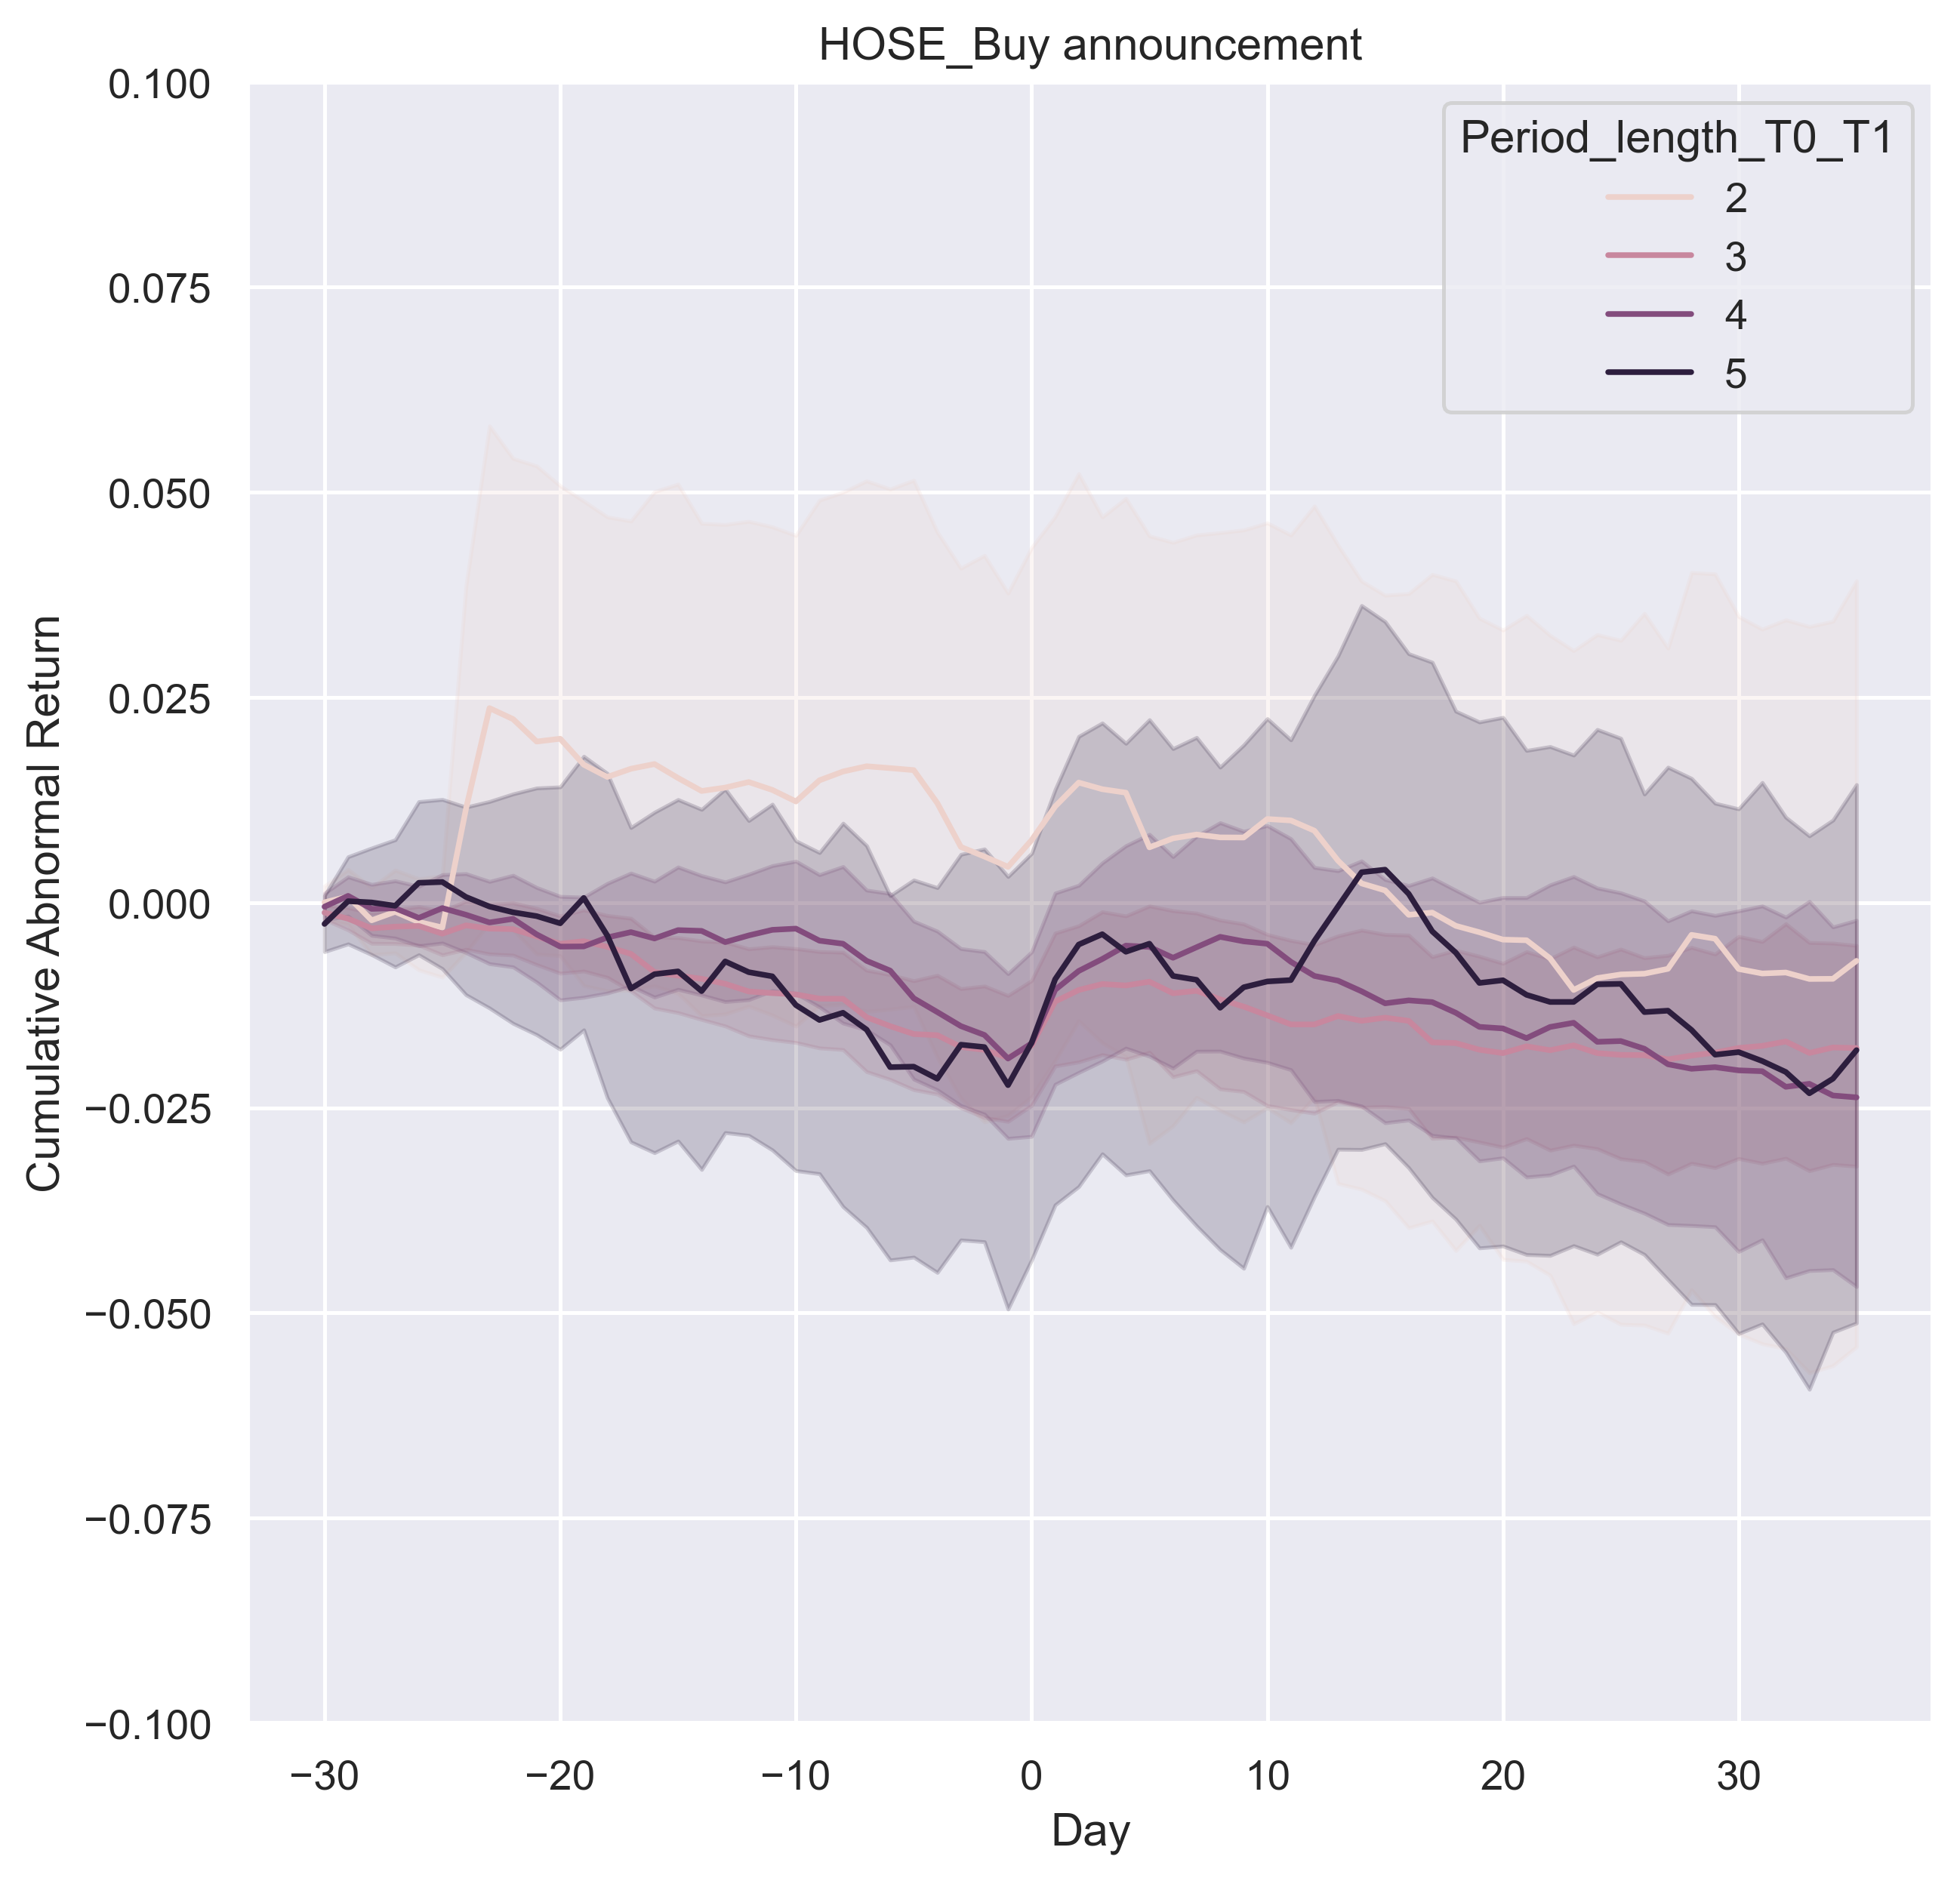

In [113]:
CAR_buy_VNI = sns.lineplot(data=df_ar_buy_VNI_2345corrected, x="Day", y="Cumulative Abnormal Return",hue="Period_length_T0_T1",ci=90)
CAR_buy_VNI.set(title='HOSE_Buy announcement')
CAR_buy_VNI.set(ylim=(-0.1, 0.1))

plt.savefig("CAR_buy_VNI.png")

#CMAR_buy_VNI.figure.savefig("CMAR_buy_VNI.png")

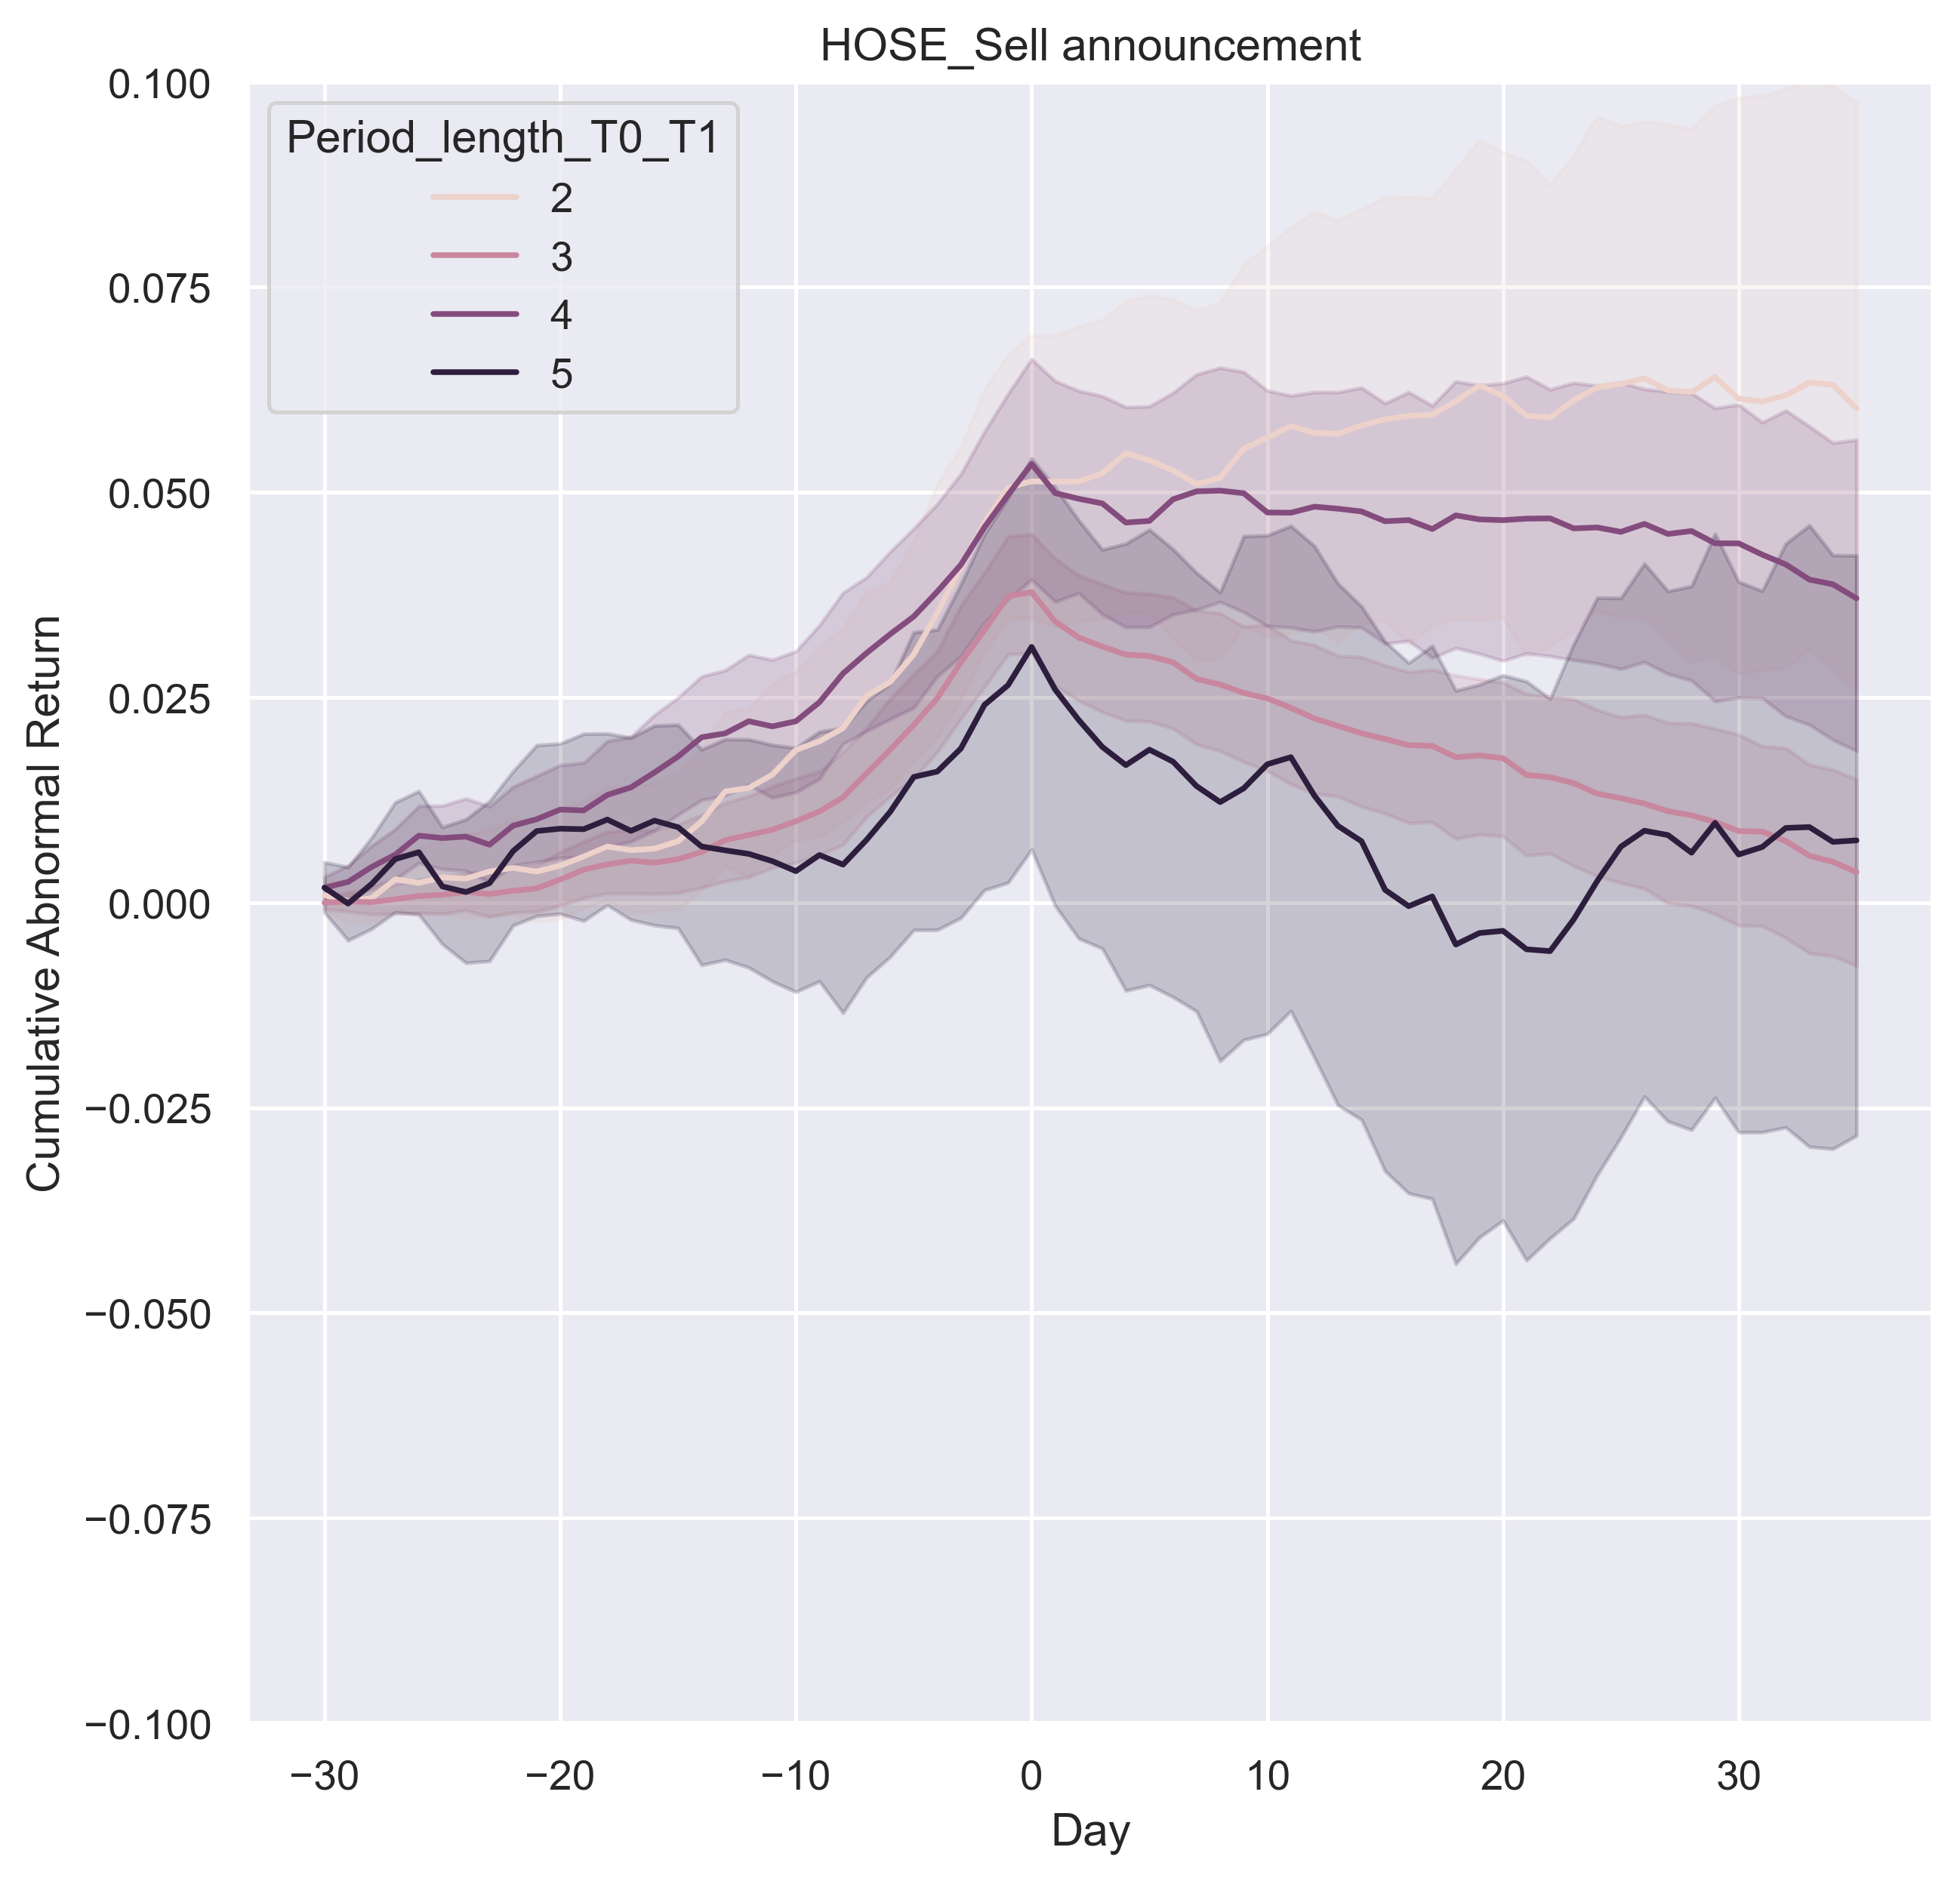

In [114]:
ar_sell_VNI = cal_ar_nosum(df_VNI_sell,254,320,540,606)

df_ar_sell_VNI = pd.DataFrame(ar_sell_VNI, index=[df_VNI_sell.index], columns= [i for i in range(-30,36)]) 
df_ar_sell_VNI = df_ar_sell_VNI.cumsum(axis=1)

df_ar_sell_VNI['Period_length_T0_T1']= df_VNI_sell['Diff_days_T0_T1'].values
df_ar_sell_VNI_2345 = df_ar_sell_VNI[(df_ar_sell_VNI['Period_length_T0_T1']<=5)&(df_ar_sell_VNI['Period_length_T0_T1']>=2)]

df_ar_sell_VNI_2345corrected = pd.DataFrame(df_ar_sell_VNI_2345.set_index('Period_length_T0_T1').stack())
df_ar_sell_VNI_2345corrected.index.set_names('Day', level=len(df_ar_sell_VNI_2345corrected.index.names)-1, inplace=True)
df_ar_sell_VNI_2345corrected.columns = ['Cumulative Abnormal Return']

CAR_sell_VNI = sns.lineplot(data=df_ar_sell_VNI_2345corrected, x="Day", y="Cumulative Abnormal Return",hue="Period_length_T0_T1",ci=90)
CAR_sell_VNI.set(title='HOSE_Sell announcement')
CAR_sell_VNI.set(ylim=(-0.1, 0.1))


plt.savefig("CAR_sell_VNI.png")

#CMAR_sell_VNI.figure.savefig("CMAR_sell_VNI.png")

In [92]:
#Plot the trend of Trading volume in (-30,+35)
cols =['StockCode','RegisterDate']

#Match Securities Trading Vol
#of buy news 
for x in range(-30,0):
    df_VNI_buy['Vol_T1_' + str(x)] = df_VNI_buy.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['TotalVol'].shift(x))

df_VNI_buy['Vol_T1_0'] = df_VNI_buy.set_index(cols).index.map(df_1121_dup.set_index(cols)['TotalVol'])

for x in range(1,36):
    df_VNI_buy['Vol_T1_' + str(x)] = df_VNI_buy.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['TotalVol'].shift(x))
    
#of sell news
for x in range(-30,0):
    df_VNI_sell['Vol_T1_' + str(x)] = df_VNI_sell.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['TotalVol'].shift(x))

df_VNI_sell['Vol_T1_0'] = df_VNI_sell.set_index(cols).index.map(df_1121_dup.set_index(cols)['TotalVol'])

for x in range(1,36):
    df_VNI_sell['Vol_T1_' + str(x)] = df_VNI_sell.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['TotalVol'].shift(x))

In [93]:
#Match Securities Outstanding Shares
#of buy news 
for x in range(-30,0):
    df_VNI_buy['TOS_T1_' + str(x)] = df_VNI_buy.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['KLCPLH'].shift(x))

df_VNI_buy['TOS_T1_0'] = df_VNI_buy.set_index(cols).index.map(df_1121_dup.set_index(cols)['KLCPLH'])

for x in range(1,36):
    df_VNI_buy['TOS_T1_' + str(x)] = df_VNI_buy.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['KLCPLH'].shift(x))
    
#of sell news
for x in range(-30,0):
    df_VNI_sell['TOS_T1_' + str(x)] = df_VNI_sell.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['KLCPLH'].shift(x))

df_VNI_sell['TOS_T1_'] = df_VNI_sell.set_index(cols).index.map(df_1121_dup.set_index(cols)['KLCPLH'])

for x in range(1,36):
    df_VNI_sell['TOS_T1_' + str(x)] = df_VNI_sell.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['KLCPLH'].shift(x))

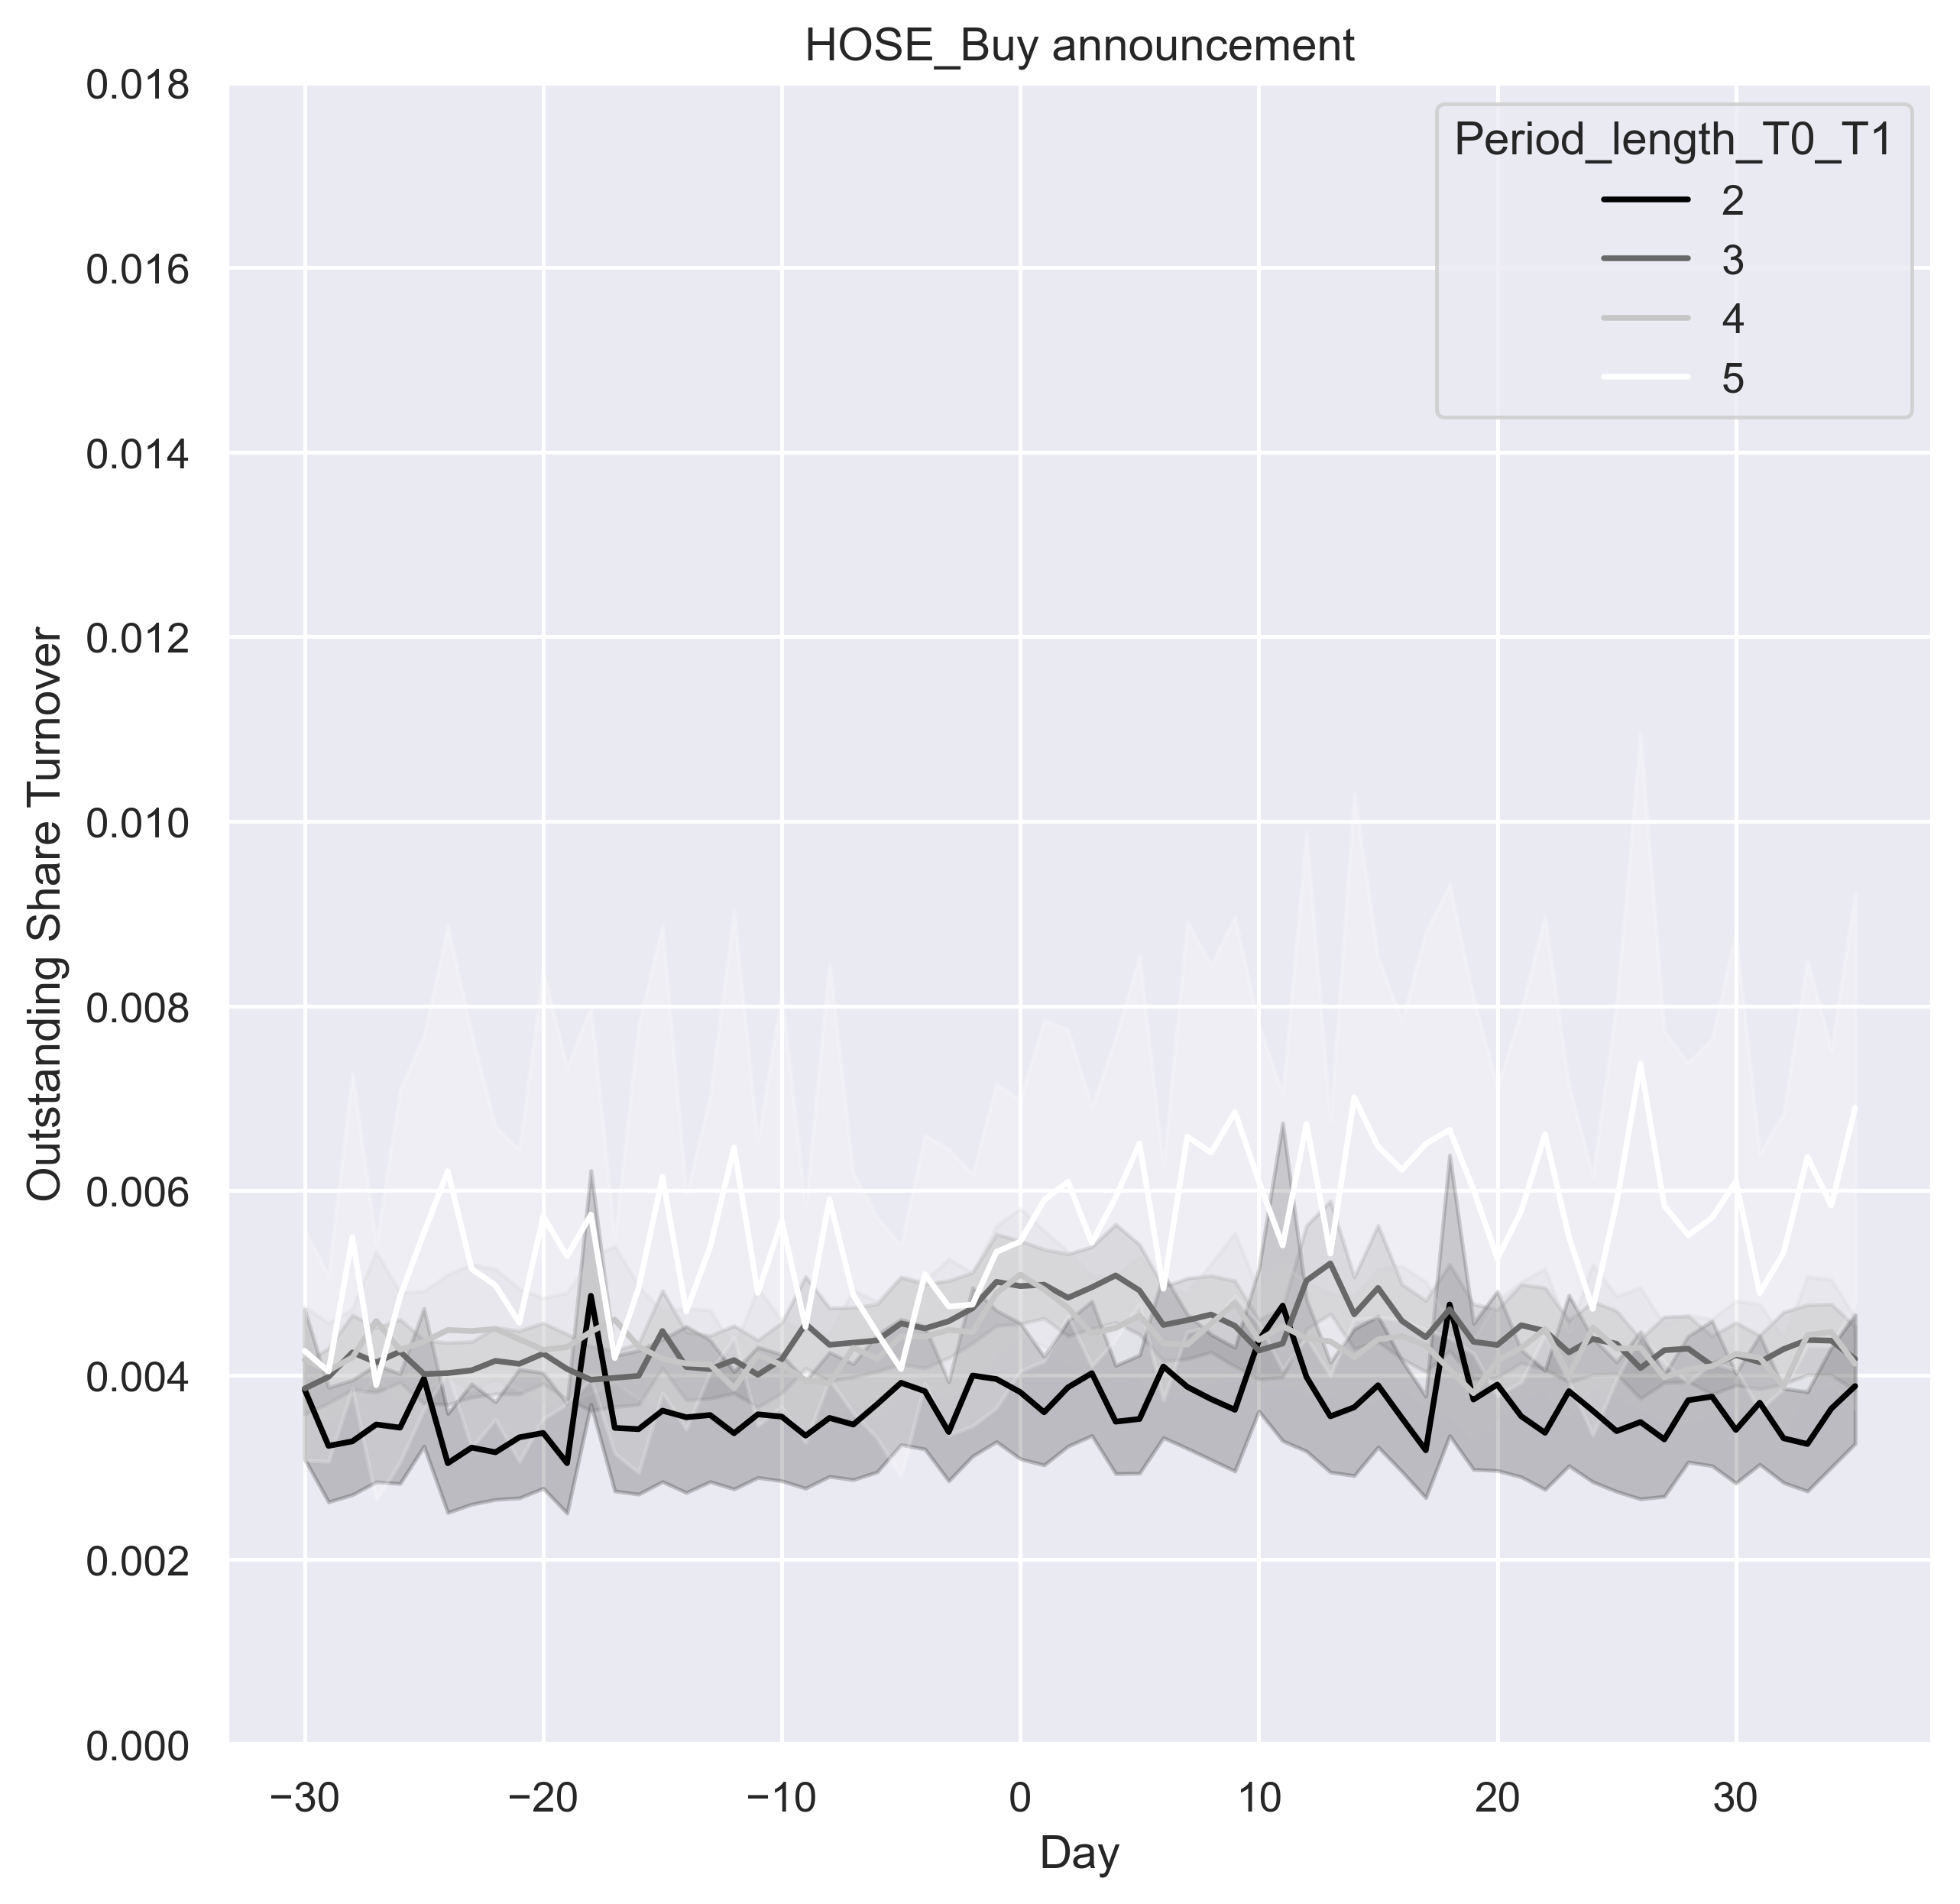

In [94]:
df_buy_vol_VNI = df_VNI_buy.iloc[:,608:674].copy()
df_buy_tos_VNI = df_VNI_buy.iloc[:,674:740].copy()
df_buy_turnover_VNI = df_buy_vol_VNI.div(df_buy_tos_VNI.values)
df_buy_turnover_VNI['Period_length_T0_T1'] = df_VNI_buy['Diff_days_T0_T1'].values
df_buy_turnover_VNI.columns = [i for i in range(-30,37)]
df_buy_turnover_VNI.rename({36: 'Period_length_T0_T1'}, axis=1, inplace=True)

df_buy_turnover_VNI_new = df_buy_turnover_VNI[(df_buy_turnover_VNI['Period_length_T0_T1']<=5)&(df_buy_turnover_VNI['Period_length_T0_T1']>=2)]
df_buy_turnover_VNI_corrected = pd.DataFrame(df_buy_turnover_VNI_new.set_index('Period_length_T0_T1').stack())
df_buy_turnover_VNI_corrected.index.set_names('Day', level=len(df_buy_turnover_VNI_corrected.index.names)-1, inplace=True)
df_buy_turnover_VNI_corrected.columns = ['Outstanding Share Turnover']

OST_buy = sns.lineplot(data=df_buy_turnover_VNI_corrected, x="Day", y="Outstanding Share Turnover",hue="Period_length_T0_T1",ci=90,palette="Greys_r")
OST_buy.set(title='HOSE_Buy announcement')
OST_buy.set(ylim=(0, 0.018))


plt.savefig("OST_buy_VNI.png")

#OST_buy.figure.savefig("OST_buy_VNI.png")

#df_VNI_buy.columns.get_indexer(['Vol_T1_-30', 'Vol_T1_35','TOS_T1_-30', 'TOS_T1_35'])
#array([608, 673, 674, 739])

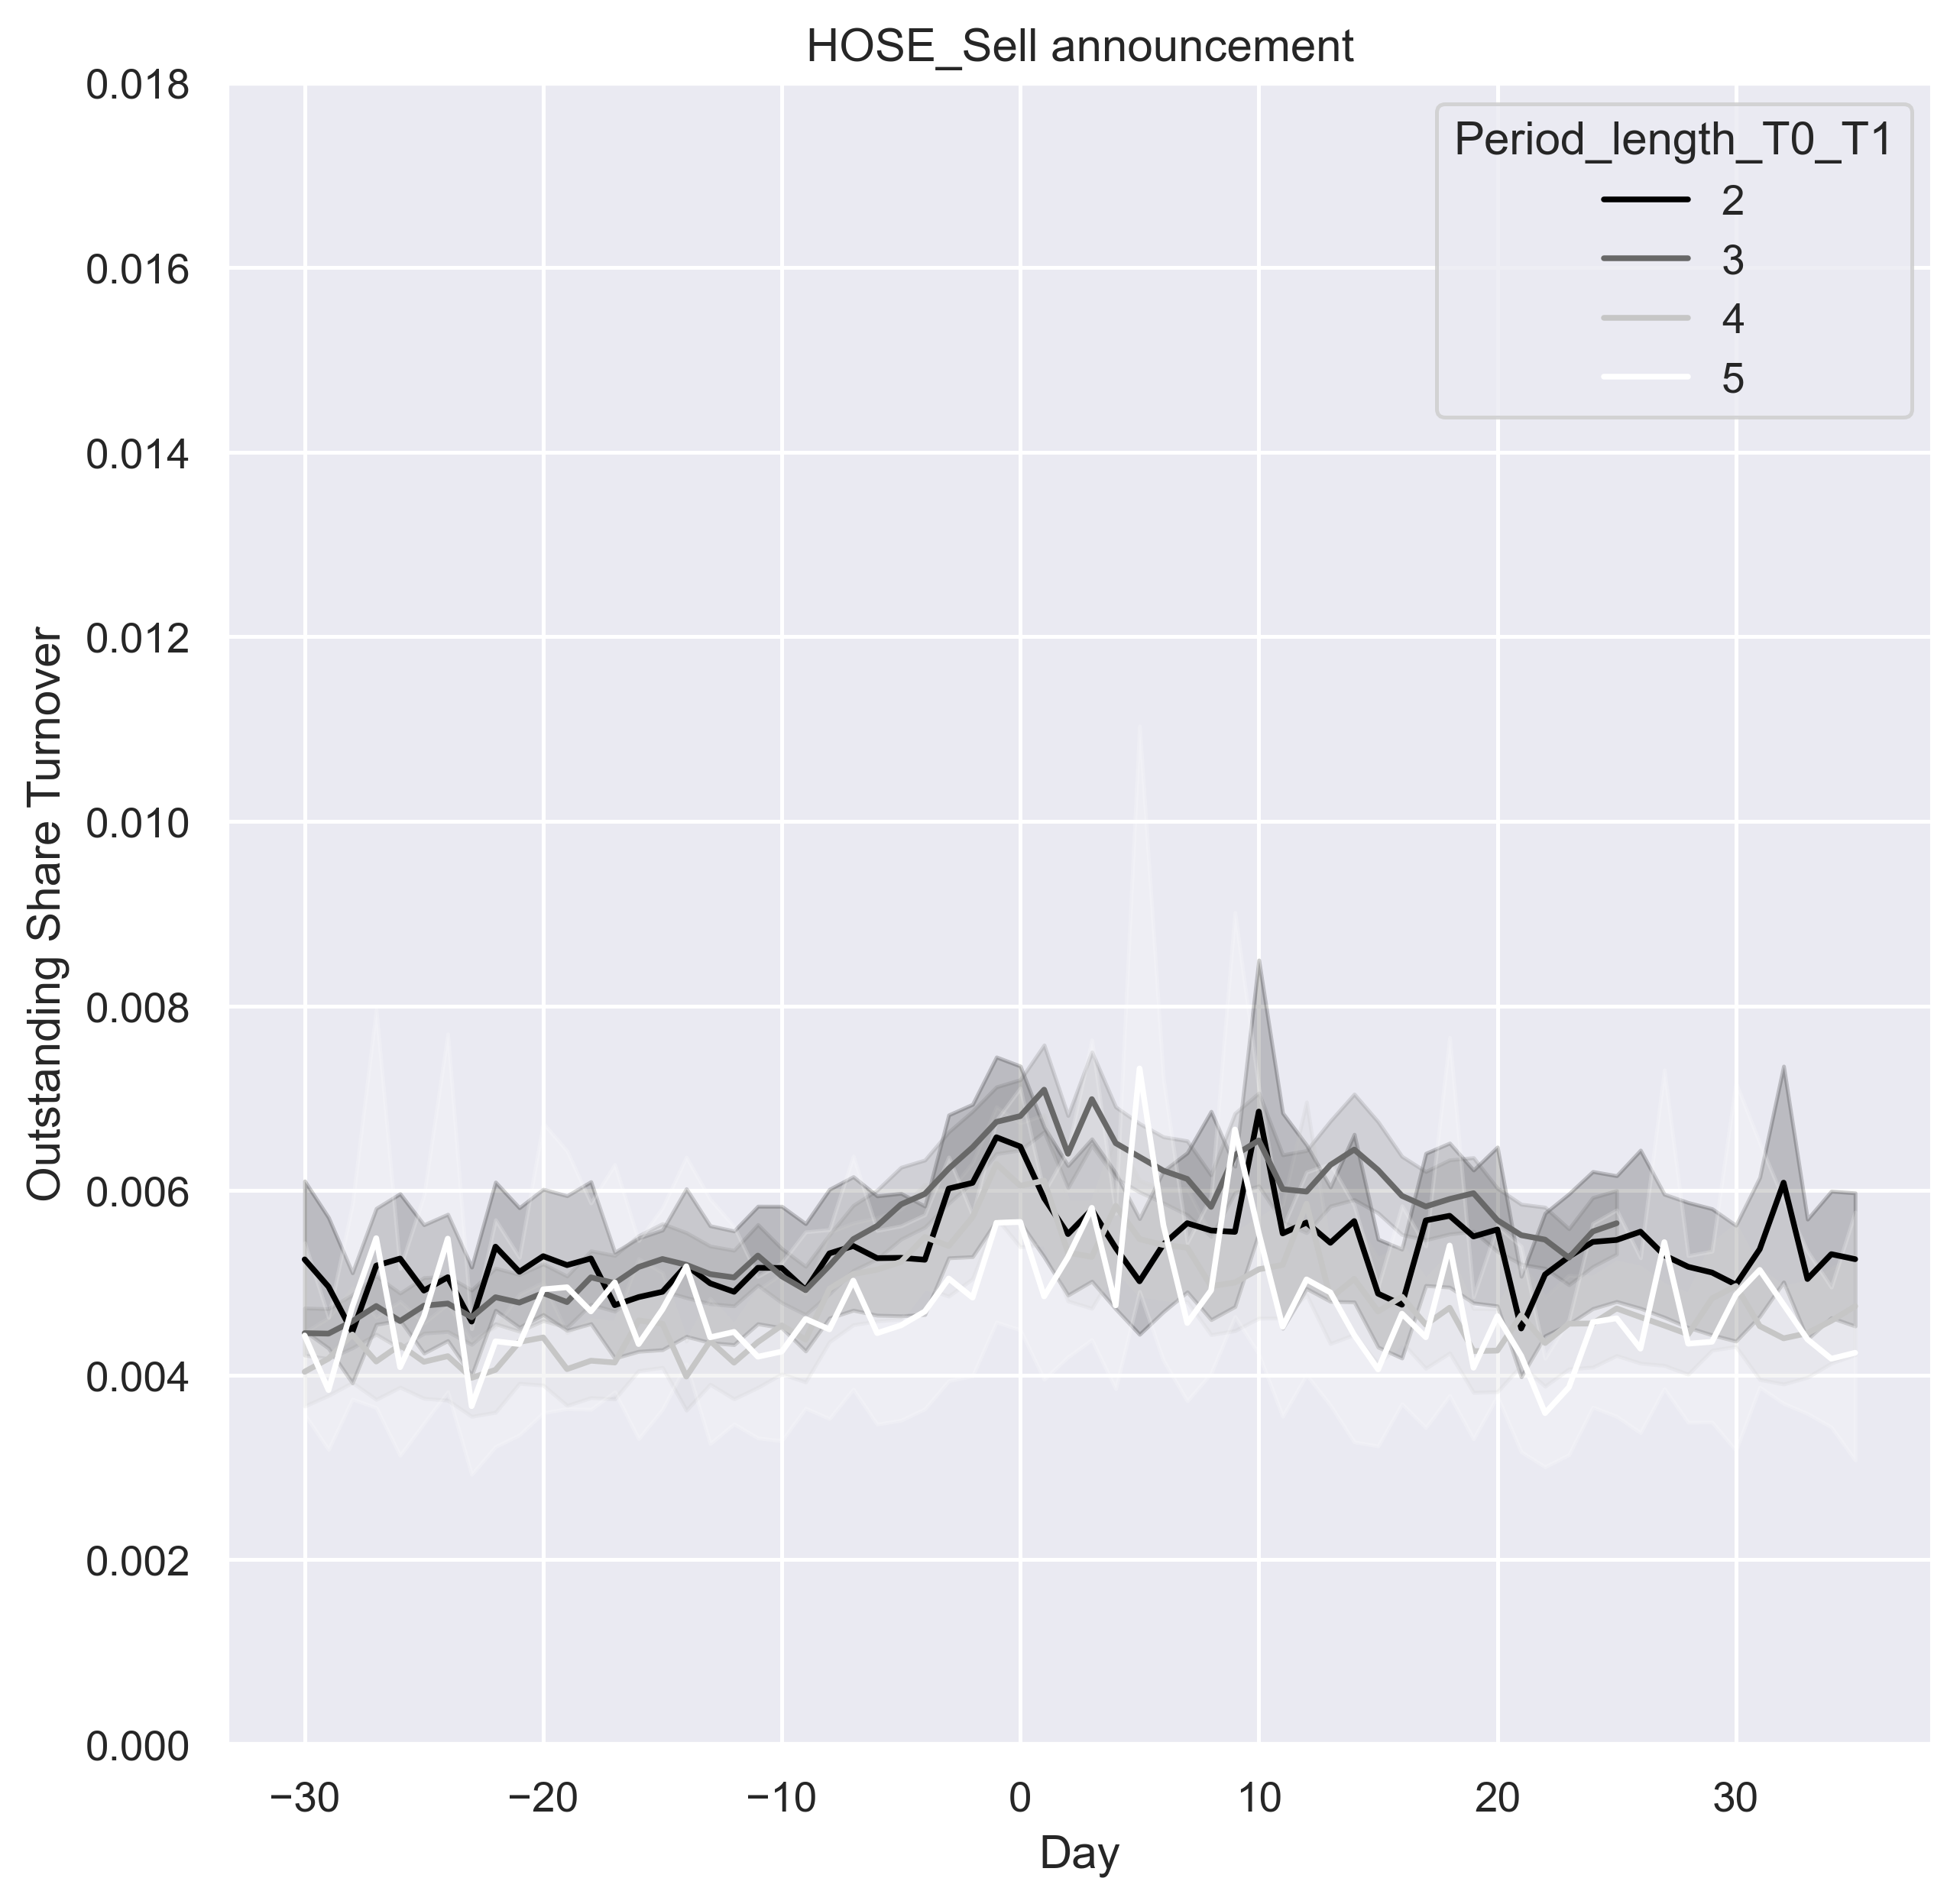

In [95]:
df_sell_vol_VNI = df_VNI_sell.iloc[:,608:674].copy()
df_sell_tos_VNI = df_VNI_sell.iloc[:,674:740].copy()
df_sell_turnover_VNI = df_sell_vol_VNI.div(df_sell_tos_VNI.values)
df_sell_turnover_VNI['Period_length_T0_T1'] = df_VNI_sell['Diff_days_T0_T1'].values
df_sell_turnover_VNI.columns = [i for i in range(-30,37)]
df_sell_turnover_VNI.rename({36: 'Period_length_T0_T1'}, axis=1, inplace=True)

df_sell_turnover_VNI_new = df_sell_turnover_VNI[(df_sell_turnover_VNI['Period_length_T0_T1']<=5)&(df_sell_turnover_VNI['Period_length_T0_T1']>=2)]
df_sell_turnover_VNI_corrected = pd.DataFrame(df_sell_turnover_VNI_new.set_index('Period_length_T0_T1').stack())
df_sell_turnover_VNI_corrected.index.set_names('Day', level=len(df_sell_turnover_VNI_corrected.index.names)-1, inplace=True)
df_sell_turnover_VNI_corrected.columns = ['Outstanding Share Turnover']

OST_sell = sns.lineplot(data=df_sell_turnover_VNI_corrected, x="Day", y="Outstanding Share Turnover",hue="Period_length_T0_T1",ci=90,palette="Greys_r")
OST_sell.set(title='HOSE_Sell announcement')
OST_sell.set(ylim=(0, 0.018))


plt.savefig("OST_sell_VNI.png")

#OST_sell.figure.savefig("OST_sell_VNI.png")